In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg


plt.style.use('seaborn')
%matplotlib inline

# 1. The Validation Set Approach

In [2]:
auto = sm.datasets.get_rdataset('Auto', 'ISLR').data.dropna()\
        .reset_index(drop=True)

In [3]:
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
np.random.seed(1)
train = np.random.choice(392, 196, replace=False)

In [5]:
lm = smf.ols('mpg ~ horsepower', data=auto, subset=train).fit()

In [6]:
not_train = auto.index.difference(train)
(
    (
    auto.loc[not_train, 'mpg'] - 
    lm.predict(auto.loc[not_train, 'horsepower'])
    ) ** 2
).mean()

23.36190289258723

In [7]:
lm2 = smf.ols('mpg ~ np.vander(horsepower, 3) - 1', 
             data=auto, subset=train).fit()

(
    (
    auto.loc[not_train, 'mpg'] - 
    lm2.predict(auto.loc[not_train, 'horsepower'])
    ) ** 2
).mean()

20.25269085834794

In [8]:
lm3 = smf.ols('mpg ~ np.vander(horsepower, 4) - 1', 
             data=auto, subset=train).fit()

(
    (
    auto.loc[not_train, 'mpg'] - 
    lm3.predict(auto.loc[not_train, 'horsepower'])
    ) ** 2
).mean()

20.32560936621836

In [9]:
np.random.seed(2)
train = np.random.choice(392, 196, replace=False)
not_train = auto.index.difference(train)

In [10]:
lm = smf.ols('mpg ~ horsepower', data=auto, subset=train).fit()

(
    (
    auto.loc[not_train, 'mpg'] - 
    lm.predict(auto.loc[not_train, 'horsepower'])
    ) ** 2
).mean()

25.10853905288968

In [11]:
lm2 = smf.ols('mpg ~ np.vander(horsepower, 3) - 1', 
             data=auto, subset=train).fit()

(
    (
    auto.loc[not_train, 'mpg'] - 
    lm2.predict(auto.loc[not_train, 'horsepower'])
    ) ** 2
).mean()

19.722533470492515

In [12]:
lm3 = smf.ols('mpg ~ np.vander(horsepower, 4) - 1', 
             data=auto, subset=train).fit()

(
    (
    auto.loc[not_train, 'mpg'] - 
    lm3.predict(auto.loc[not_train, 'horsepower'])
    ) ** 2
).mean()

19.921367860047578

# 2. Leave-One-Out Cross-Validation

In [13]:
lm = smf.ols('mpg ~ horsepower', data=auto).fit()
lm.params

Intercept     39.935861
horsepower    -0.157845
dtype: float64

In [14]:
glm = smf.glm('mpg ~ horsepower', data=auto).fit()
glm.params

Intercept     39.935861
horsepower    -0.157845
dtype: float64

In [15]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

In [16]:
X = auto[['horsepower']]
y = auto['mpg']

model = LinearRegression()

cv = LeaveOneOut()

scores = cross_val_score(model, X, y, cv=cv,
                         scoring='neg_mean_squared_error')

In [17]:
scores.mean()

-24.231513517929226

In [18]:
error1 = np.zeros(10)

for i in range(10):
    poly = PolynomialFeatures(degree=i+1, include_bias=False)
    poly_features = poly.fit_transform(X)
    poly_reg_model = LinearRegression()
    cv = LeaveOneOut()
    scores = cross_val_score(poly_reg_model, poly_features, y, cv=cv,
                             scoring='neg_mean_squared_error')
    error1[i] = -scores.mean()

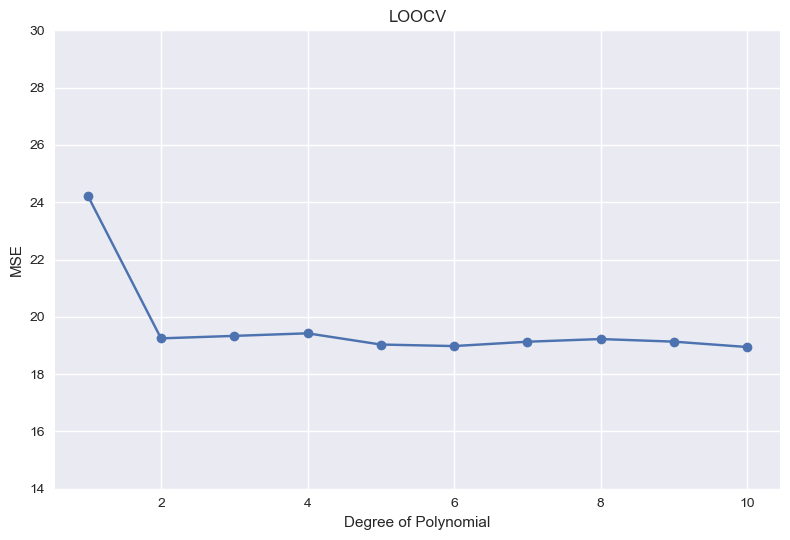

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 11), error1, '-o')
ax.set_ylim(14, 30)
ax.set(title='LOOCV', xlabel='Degree of Polynomial', ylabel='MSE')
plt.tight_layout()

# 3. k-Fold Cross-Validation

In [20]:
error2 = np.zeros(10)

for i in range(10):
    poly = PolynomialFeatures(degree=i+1, include_bias=False)
    poly_features = poly.fit_transform(X)
    poly_reg_model = LinearRegression()
    cv = KFold(10, random_state=17, shuffle=True)
    scores = cross_val_score(poly_reg_model, poly_features, y, cv=cv,
                             scoring='neg_mean_squared_error')
    error2[i] = -scores.mean()

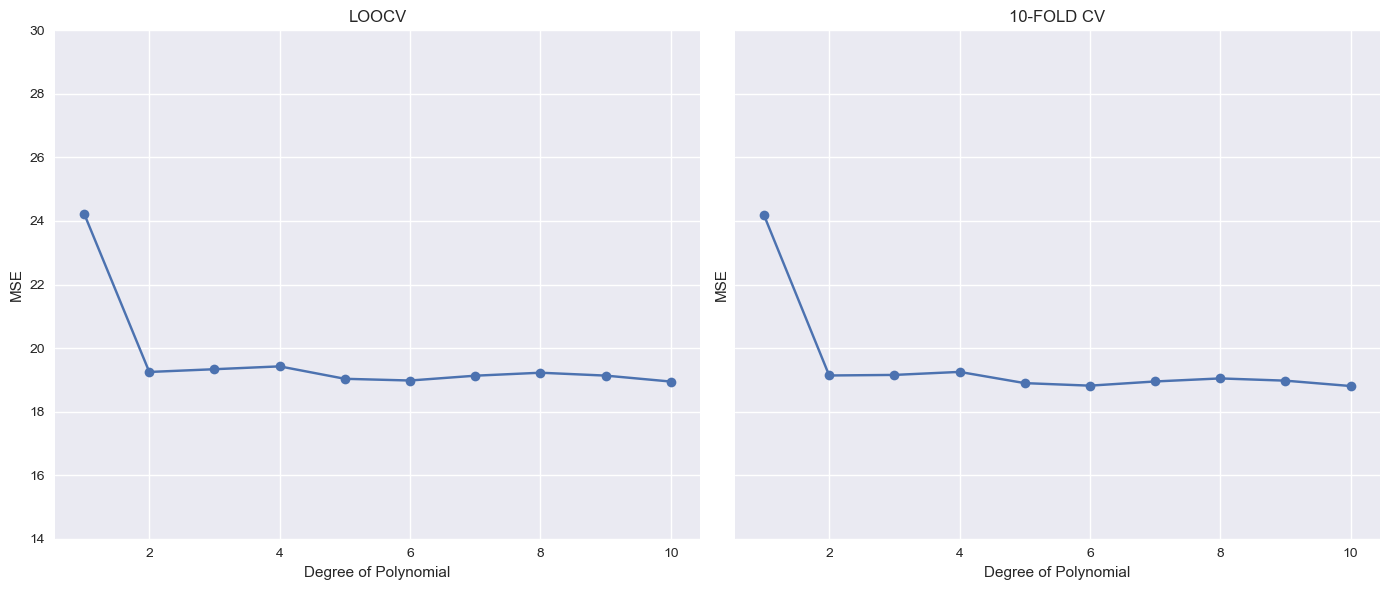

In [21]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 6))

ax[0].plot(np.arange(1, 11), error1, '-o')
ax[0].set_ylim(14, 30)
ax[0].set(title='LOOCV', xlabel='Degree of Polynomial', ylabel='MSE')

ax[1].plot(np.arange(1, 11), error2, '-o')
ax[1].set(title='10-FOLD CV', xlabel='Degree of Polynomial', ylabel='MSE')

plt.tight_layout()

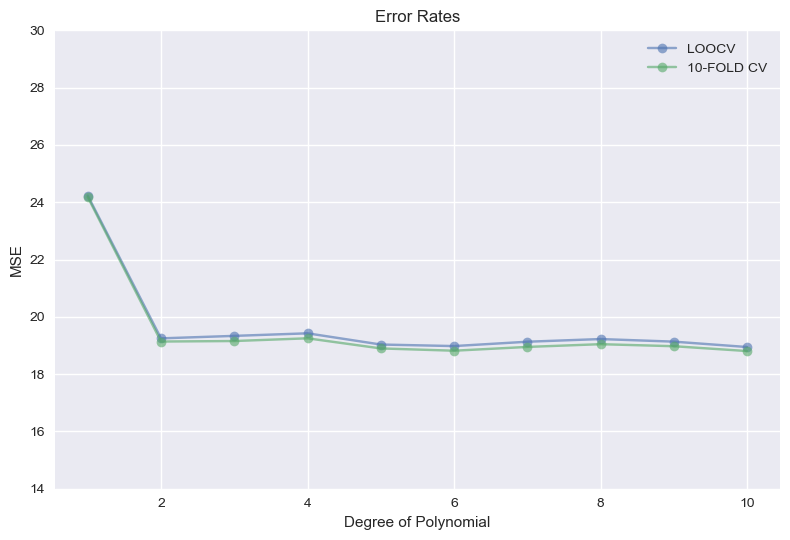

In [22]:
fig, ax = plt.subplots()

ax.plot(np.arange(1, 11), error1, '-o', label='LOOCV', alpha=0.6)
ax.plot(np.arange(1, 11), error2, '-o', label='10-FOLD CV', alpha=0.6)

ax.set_ylim(14, 30)
ax.set(title='Error Rates', xlabel='Degree of Polynomial', ylabel='MSE')
ax.legend()

plt.tight_layout()

# 4. The Bootstrap

## Estimating the Accuracy of a Statistic of Interest

In [23]:
portfolio = sm.datasets.get_rdataset('Portfolio', 'ISLR').data

In [24]:
portfolio.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


In [25]:
from sklearn.utils import resample

In [26]:
def alpha(data, index):
    data = data.loc[index]
    cov_mat = data.cov()
    return np.array((cov_mat.loc['Y', 'Y'] - cov_mat.loc['X', 'Y']) / (
        cov_mat.loc['X', 'X'] + cov_mat.loc['Y', 'Y'] - 2*cov_mat.loc['X', 'Y']
    ))

In [27]:
alpha(portfolio, portfolio.index)

array(0.57583207)

In [28]:
def boot(data, func, R=1000):
    
    original = func(data, data.index)
    stats = np.zeros((R, *original.shape))
    
    for i in range(R):
        resample_index = resample(data.index, replace=True)
        stats[i] = func(data, resample_index)
        
    bias = stats.mean(axis=0) - original
    se = stats.std(axis=0, ddof=1)
    
    return original, bias, se

In [29]:
original, bias, se = boot(portfolio, alpha)

In [30]:
print(f"""
Original: {original}
Bias: {bias}
Std Error: {se}
""")


Original: 0.57583207459283
Bias: 0.00419144491423884
Std Error: 0.09319601588604272



## Estimating the Accuracy of a Linear Regression Model

In [31]:
def lin_coefs(data, index):  
    lm = smf.ols('mpg ~ horsepower', data=data, subset=index).fit()
    return lm.params

In [32]:
lin_coefs(auto, auto.index)

Intercept     39.935861
horsepower    -0.157845
dtype: float64

In [33]:
lin_coefs(auto, resample(auto.index))

Intercept     38.258226
horsepower    -0.147286
dtype: float64

In [34]:
lin_coefs(auto, resample(auto.index))

Intercept     39.166792
horsepower    -0.149524
dtype: float64

In [35]:
lm = smf.ols('mpg ~ horsepower', data=auto).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           7.03e-81
Time:                        11:29:56   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
original, bias, se = boot(auto, lin_coefs)

In [37]:
original

Intercept     39.935861
horsepower    -0.157845
dtype: float64

In [38]:
bias

Intercept     0.010450
horsepower   -0.000248
dtype: float64

In [39]:
se

array([0.8455551 , 0.00730478])

In [40]:
def quad_coefs(data, index):  
    lm = smf.ols('mpg ~ horsepower + I(horsepower**2)', data=data, subset=index).fit()
    return lm.params

In [41]:
original, bias, se = boot(auto, quad_coefs)

In [42]:
original

Intercept             56.900100
horsepower            -0.466190
I(horsepower ** 2)     0.001231
dtype: float64

In [43]:
bias

Intercept             0.023260
horsepower           -0.000493
I(horsepower ** 2)    0.000002
dtype: float64

In [44]:
se

array([2.02004232e+00, 3.22056093e-02, 1.16196977e-04])

In [45]:
lm = smf.ols('mpg ~ horsepower + I(horsepower**2)', data=auto).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Fri, 07 Oct 2022   Prob (F-statistic):           5.40e-99
Time:                        11:30:26   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             56.9001      1.800     31.604      0.000      53.360      60.440
horsepower            -0.4662      0.031    -14.978      0.000      -0.527      -0.405
I(horsepower ** 2)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""